# Report - ProgrammingTask

#### Scope of the Project
Time series forecasting for blood glucose (BG) values provides valuable information for improving the insulin management for patients with type 1 diabetes (PwT1D). Reliable BG forecasting holds the potential to improve the automated meal announcement and possible insulin treatment (bolus dose, and basal rate) adjustments. Further, certain events could trigger alarms to inform the patient with respect to risks of potential future hypo- or hyperglycemia. However, the problem complexity, the related uncertainties, as well as the inter- and intra-patient variabilities, makes challenging the accurate prediction of future glucose concentrations. To address these challenges, we make benefit of recent advances in deep learning. 

In this report I will remake a simple LSTM model that will forecast blood gucose levels based on recorded data from 6 pariciants utlizing information such as continuous glucose monitoring (CGM), basal insulin rate, bolus injection, plus the patient’s carbohydrate estimate for the meal. Drawing inspiration from the transfer learning research outlined in [2], I explored the impact of training models tailored to each participant versus models designed for general use. This included an investigation into the effects of transfer learning compared to models built from scratch using data from all participants.


The report will go though:
- Dataset Analysis: Exploring dataset features.
- Data Preparation and Scaling: Steps for data preprocessing and feature scaling.
- Experiment Setup: Outline of design choices and experimental setup.
- Results: Presentation of experimental findings.
- Conclusion and Comparison: Key insights and comparison with current BG prediction methods.
- Future Work: Suggestions for further research.

Relevant sections will include executable code.

Before we get going, we need to import necessary libraries:

In [41]:
from dataprepper import DataPrepper
from datahandler import CSVDataHandler
from models import MirshekarianLSTM
from trainer import Trainer
from evaluator import Evaluator

import torch
import torch.nn as nn
import torch.optim as optim

from datahandler import CSVDataHandler
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from torch.utils.data import TensorDataset, DataLoader
#Getting rid of the annoying warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Dataset
### Ohio Dataset
The dataset is based on data from the OhiaT1DM dataset [3], and contains:
- Continuous glucose monitoring (CGM) data, recorded every 5 minutes, for 12 people with type 1 diabetes over 8 weeks.
- Insulin doses, both bolus and basal, delivered by insulin pumps.
- Physiological sensor data, such as heart rate, galvanic skin response, and step count, 

The measurements are provided at intervals of 5 minutes. Data was gathered from six participants in 2018 using the Basis Peak physiological sensor. In 2020, the same data was collected from an additional six participants using the Empatica Embrace bands3 physiological sensor. In this report we will only consider the data collected in 2018.

In [42]:
#Read data
participants = [559,563,570,575,588,591]
directory_path_train = os.path.join('Ohio Data', 'Ohio2018_processed', 'train')
train_handler = CSVDataHandler(directory_path_train, 'train')
train_handler.load_csv_files()


#### Short Feature Analysis
To get a better understanding of the data that will be used thorugh the report we will start off with some Feature analysis.

##### Factor Distribution

This section contains histograms of all the data. I use the IQR to be able to exclude outliers which can limit the insight into the bulk of the data

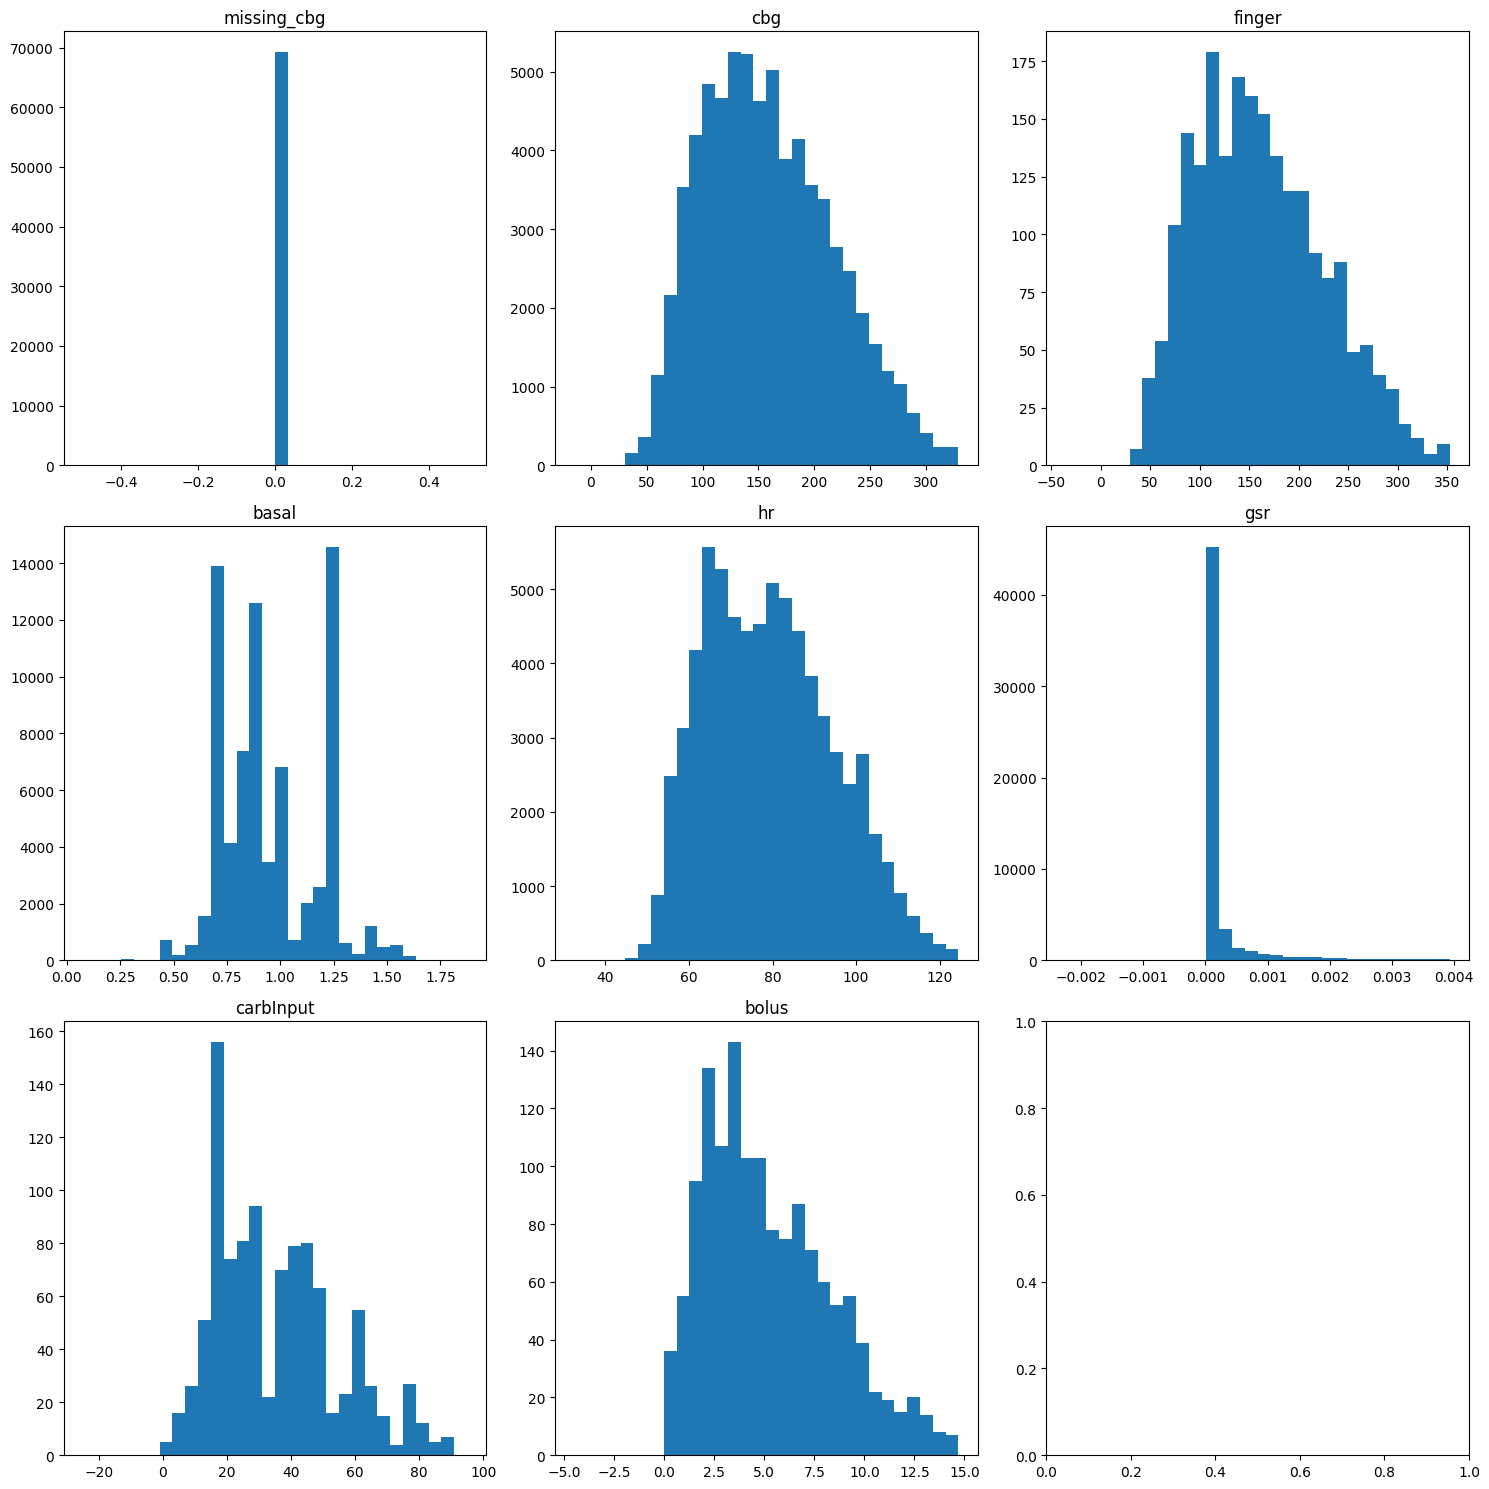

In [43]:
import math

df = train_handler.get_combined_df()
df = df.drop(columns='5minute_intervals_timestamp')
quantiles = df.quantile([0.25, 0.75])
Q1 = quantiles.loc[0.25]
Q3 = quantiles.loc[0.75]
IQR = Q3 - Q1

num_columns = 3
fig, axs = plt.subplots(math.ceil(len(df.columns) / num_columns), num_columns, figsize=(15, 15))

for i, column in enumerate(df.columns):
    axs.flat[i].hist(df[column].dropna(), range=(Q1[column] - 1.5*IQR[column], Q3[column] + 1.5*IQR[column]), bins=30)
    axs.flat[i].set_title(column)

fig.tight_layout()
plt.show()

##### CBG
The distribution of the CBG values is approximately bell-shaped, which is typical for biological measurements. The bulk of the CBG values are distributed between approximately 50 to 250.

##### Finger
The distribution of fingerstick blood glucose measurements appears similar to that of CBG, which gives some credibility to to the CBG measurements!

##### Basal
The histogram for basal insulin shows several peaks, suggesting that there are common set values for basal insulin delivery, which may correspond to typical dosing strategies or pump settings.

##### HR
The heart rate (hr) histogram appears to be roughly normally distributed, centered around a value that could be around 70-80 bpm, which is common for resting heart rates in adults.

##### CarbInput
The carbohydrate input histogram shows a right-skewed distribution with most values concentrated near 0, indicating many instances with no or low carbohydrate intake, and fewer instances with higher carbohydrate intake. Might be some snacking going on?

#### Bolus
This histogram is also right-skewed, similar to carbInput, indicating that most of the bolus insulin doses are on the lower end, with a few larger doses. 

#### Correlation Matrix

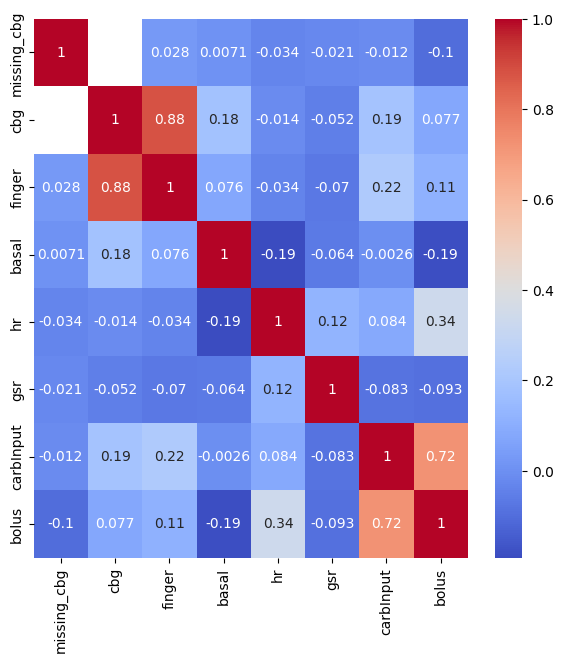

In [44]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(7,7))  # Adjust the size of the figure
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

For finger the correlation coefficient is 0.88, indicating a very strong positive correlation with cbg. I would guess this is expected since both are measurements of blood glucose levels, although possibly measured at different times or under different conditions.As finger is another blood glucose measurement, it would not be a good predictive feature on top of current cbg values...

For basal the correlation coefficient is 0.18, which is a low positive correlation. It suggests higher basal insulin is associated with higher cbg readings.

For carbInput the correlation coefficient is 0.22, also indicating a low positive correlation. This suggests that higher carbohydrate intake is be associated with higher cbg readings.

For bolus the correlation coefficient is 0.11, which is a very low positive correlation. This indicates that there is some relationship between bolus insulin dosages and cbg readings.

The other features (missing_cbg, hr, and gsr) have very low correlation coefficients with cbg.

It is also good to consider domain-specific knowledge. In diabetes management, both carbohydrate intake and insulin dosages are key factors that influence blood glucose levels, and they might have complex nonlinear relationships with cbg that aren't fully captured by a correlation coefficient. 

## Data Preparation

### Feature Selection

Drawing from the feature analysis and domain knowledge, the selected features are as follows:

In [45]:
features = ['cbg', 'basal', 'carbInput', 'bolus']

This also matches the features considered in the survey paper [1], which will allow for a more fair comparison to those models.

### Preprocessing

In the referenced survey paper [1], the authors employed cubic spline interpolation to impute missing data across all features. However, this approach might obscure the precise timing of events critical to the study, such as bolus injections and carbohydrate consumption. I therefore applied cubic spline interpolation exclusively to the continuous blood glucose (CBG) data, where temporal continuity is expected. For other features, missing values were assigned a zero, which more accurately reflects the absence of an event or measurement at those specific times.

In [46]:
fill_types = ['cubicspline', 0, 0, 0]
train_handler.handle_missing_values(features, fill_types)

### Feature scaling

As the features have different scales, normalization can help the model to converge faster and prevent the model from prioritizing certain features over others due to the scale. To do the normalization I used StandardScaler, which standardizes features by removing the mean and scaling to unit variance, bringing all of them to the same scale without distorting differences in the range of values.  While StandardScaler is robust and commonly used, it assumes that the data for each feature is normally distributed. Another thing to consider is that StandardScaler is sensitive to outliers. If the data contains many outliers, scaling can be influenced by them. It would therefor also be a good idea to consider using RobustScaler, which is less sensitive to outliers. I did not do this because of time constraints.

The scaler is only applied to the training data and use the same parameters (mean and standard deviation) to transform both the training and the test data. This prevents information from the test set leaking into the model training phase.

In [47]:
import joblib
scaler = StandardScaler()
scaler.fit(train_handler.get_combined_df()[features])
#Save scaler for later use
joblib.dump(scaler, "scalers"+os.sep+'scaler_2018.pkl')

['scalers\\scaler_2018.pkl']

## Experiments

### Design choices

#### Model Choice

The survey paper's findings indicated minimal differences in performance among the various model architectures reviewed. Given that the objective of this work is to assess the effects of training models on inter-patient versus intra-patient data, rather than to identify the optimal model architecture, I have opted for a simpler approach to reduce the possibility that model selection might influence the outcomes. The Mirshekarian Model, with its single hidden layer comprising five units, appeared to be the most straightforward and also performed well when compared to other state-of-the-art models.

Side note:The authors of "Personalised Short-Term Glucose Prediction via Recurrent Self-Attention Network" [2] reported results that were notably superior to those detailed in the survey paper. Despite the growing popularity of self-attention mechanisms, particularly in transformers, my coursework did not encompass practical experience with these models, so that will be a task for a different time.

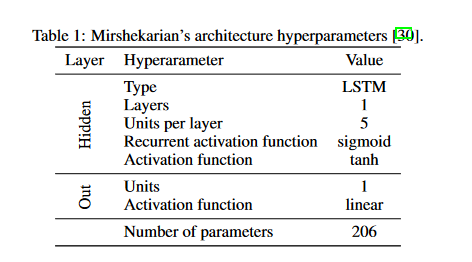

#### Hyperparameters

To not increase the scope for this project, I adopted best practice hyperparameters. The optimizer of choice was Adam. A learning rate of 0.01 was set, striking a balance between convergence speed and stability. Consistent with standard practice for regression problems, the Mean Squared Error (MSE) loss function was employed. To optimize the training duration and prevent overfitting, I implemented early stopping with a patience setting of 3, and capped the maximum number of training epochs at 100, ensuring the experiments were time-efficient.

#### Forecast Horizon

The forecast_steps parameter determines how many steps ahead in time the model will predict. I have trained the model for direct forecasting, targeting specific future intervals—30, 60, and 120 minutes. These timesteps matches with the work done in [1] [2], and will make it easier to compare the results. It's also reasonable to expect that forecasting further into the future might diminish the practical value of the predictions for blood glucose level management.

While I considered recursive forecasting, it seemed to require too many assumptions about future feature behavior, which could introduce significant uncertainty. Multi-step forecasting of all the consideres tiem-steps also crossed my mind, yet I was concerned about its potential complication of the loss function and overall model training. Hence, I decided that direct forecasting was the best approach.

In [48]:
forecast_steps = 6

All models are trained using a standardized function that requires only the relevant training data as input. The best-performing models on the validation set will be subsequently saved to the specified model_path.

### Model Training Pipeline

In [49]:
def train_model_for_programming_task(participants, scaler, model_path='best_model.pth', forecast_steps=6, pretrained_model_path=None):
    features = ['cbg', 'basal', 'carbInput', 'bolus']
    fill_types = ['cubicspline', 0, 0, 0]

    directory_path_train = os.path.join('Ohio Data', 'Ohio2018_processed', 'train')
    train_handler = CSVDataHandler(directory_path_train, 'train')
    train_handler.load_csv_files()
    train_handler.handle_missing_values(features, fill_types)

    directory_path_test = os.path.join('Ohio Data', 'Ohio2018_processed', 'test')
    test_handler = CSVDataHandler(directory_path_test, 'test')
    test_handler.load_csv_files()
    test_handler.handle_missing_values(features, fill_types)


    #initialize data prepper and make features and target pair
    prepper = DataPrepper(participants, train_handler, forecast_steps=forecast_steps, scaler=scaler)
    features_train, target_train = prepper.make_features_and_targetpair()

    # Create TensorDatasets
    ########################
    # Split the training data into training and validation sets
    features_train, features_val, target_train, target_val = train_test_split(
        features_train, target_train, test_size=0.2, random_state=42)

    # Create TensorDatasets for the training and validation sets
    train_data = TensorDataset(features_train, target_train)
    val_data = TensorDataset(features_val, target_val)

    # Create DataLoaders
    batch_size = 32
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size)
    ########################

    model = MirshekarianLSTM(input_dim=4, hidden_dim=5, output_dim=1)
    #initialize model
    if pretrained_model_path != None:
        pretrained_model_dir = os.path.dirname(pretrained_model_path)
        if not os.path.exists(pretrained_model_dir):
            os.makedirs(pretrained_model_dir)
        model.load_state_dict(torch.load(pretrained_model_path))


    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Train the model
    trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, model_path=model_path)

    trainer.train()

#train_model_for_programming_task([559,563,570,575,588,591])


### Forcasting models

Drawing inspiration from the transfer learning research outlined in [2], I explored the impact of training models tailored to each participant versus models designed for general use. This included an investigation into the effects of transfer learning compared to models built from scratch using data from all participants. This section will detail the advantages and disadvantages of these varying approaches, along with their implementation in the context of this report's work.

#### Inter-patient Model
An inter-patient model is trained on data from multiple patients and is intended to be generalizable across new patients, has several potential benefits in the context of healthcare and medical predictions. It captures the underlying patterns that are common across different individuals, leading to a model that is more likely to perform well on new patients who were not part of the training data. Once developed, an inter-patient model can be deployed at scale without the need for individualized training, making it more practical and cost-effective for widespread use in clinical settings. By leveraging data from multiple patients, these models can learn from a much larger and more varied dataset than single-patient models. This can be especially valuable in cases where data from individual patients is limited. Models trained on a diverse set of patient data are more likely to be robust to variations in data that can occur due to differences in demographics, disease progression, treatment responses, and measurement devices. 

However, there are also challenges associated with inter-patient models, such as the need to handle inter-patient variability and the risk of models being biased towards patient subgroups that are overrepresented in the training data. 

In [ ]:
# Train one model from all data from all participants except test participant

for participant in participants:
    train_participants = [p for p in participants if p != participant]
    model_path = os.path.join('models', 'inter-patient', str(forecast_steps), f'best_model_{participant}.pth')
    train_model_for_programming_task(train_participants, scaler, model_path, forecast_steps)

#### Intra-patient Model
An intra-patient model trained using data from a single patient. This type of model is tailored to the individual characteristics and data patterns specific to that patient. Because the model is trained on data from a single patient, it can become highly sensitive to the subtle changes and trends within that patient’s data, which might be overlooked in models trained on data from multiple patients. With intra-patient models, the risk of overfitting to a particular patient's data is not necessarily a downside, as the model is intended to be patient-specific. On the flip side, an intra-patient model can quickly adapt to new data from the patient, making it well-suited for conditions where the patient’s state can change rapidly.

Intra-patient models also come with challenges. A single patient may not generate enough data to train a robust model, leading to issues with underfitting or poor generalization to new states or conditions not present in the training data. These models are not intended to be applied to other patients, which limits their broader applicability. Personalized models require regular updates as new data becomes available or the patient’s condition changes, which can be resource-intensive. There may be more variability in a single patient’s data due to factors like measurement errors, lifestyle changes, or unrecorded interventions, which can affect the model’s performance.


In [ ]:
# Train one model per participant from only data from that participant

for participant in participants:
    train_participants = [participant]
    model_path = os.path.join('models', 'intra-patient', str(forecast_steps), f'best_model_{participant}.pth')
    train_model_for_programming_task(train_participants, scaler, model_path, forecast_steps)

#### Inter- and intra-patient Model
Creating a model that integrates both intra-patient and inter-patient data can be highly beneficial, as it attempts to leverage the strengths of both approaches. This hybrid model can be designed to generalize across a population while also adapting to individual-specific data. Such a model can learn general patterns from a larger population and fine-tune predictions for individual patients using their specific data. By training on diverse data from multiple patients, the model can learn to be robust to a variety of conditions and may improve its predictive accuracy for any single patient by understanding broader patterns.

For patients with limited historical data, the inter-patient component can provide a solid foundation, and as more personal data becomes available, the intra-patient component can start to play a larger role. However, there are also challenges associated with creating a hybrid model. The model may become more complex as it tries to capture both individual variability and common patterns across patients. Training a hybrid model can also be computationally intensive, as it may require retraining on the whole dataset each time new data from a specific subject is added.

In [ ]:
#Trained on data from all participants
for participant in participants:
    train_participants = participants
    model_path = os.path.join('models', 'inter_and_intra-patient', str(forecast_steps), f'best_model_{participant}.pth')
    train_model_for_programming_task(train_participants, scaler, model_path, forecast_steps)

#### Inter- and intra-patient Model - Transfer Learning
Training a model from scratch on large datasets requires significant computational resources and time. Transfer learning can reduce this burden by utilizing a model that has already learned features from a large dataset beafore reatraining it to the target subject. Many features learned from the larger dataset are often relevant to individual patients. Transfer learning allows these features to be refined rather than learned from scratch, leveraging hierarchical feature representations that are beneficial for the specific patient’s predictions.Transfer learning can also be applied even when the new patient data becomes available in incremental batches. The model can be updated iteratively, which is more challenging with traditional training approaches.

In [ ]:
# First pretrained on data from all patients. Then trained on data for the specific patient

for participant in participants:
    train_participants = [participant]
    pretrained_model_path = os.path.join('models', 'inter-patient', str(forecast_steps), f'best_model_{participant}.pth')
    model_path = os.path.join('models', 'inter_and_intra-patient_trans', str(forecast_steps), f'best_model_{participant}.pth')
    train_model_for_programming_task(train_participants, scaler, model_path, forecast_steps, pretrained_model_path)

## Results

This section presents the results of the predictive models evaluated across the three forecasting horizons. For each model, the Root Mean Squared Error (RMSE) scores, complemented by a violin plot of their performance are provided. 
The models examined are:
- Inter-patient Model
- Intra-patient Model
- Inter- and Intra-patient Model
- Inter- and Intra-patient Model with Transfer Learning

For a detailed evaluation, I have prepared separate reports for each forecast horizon: 
https://github.com/knutjstr/ProgrammingTask/blob/main/Report_forecast_30min.ipynb
https://github.com/knutjstr/ProgrammingTask/blob/main/Report_forecast_60min.ipynb
https://github.com/knutjstr/ProgrammingTask/blob/main/Report_forecast_120min.ipynb

In these individual reports, you will find detailed plots illustrating the predicted versus actual values for each model on each participant. This visual comparison provides intuitive insights into model performance and illustrates the impact of extending the forecast horizon on prediction accuracy.

### 30 minute forecast

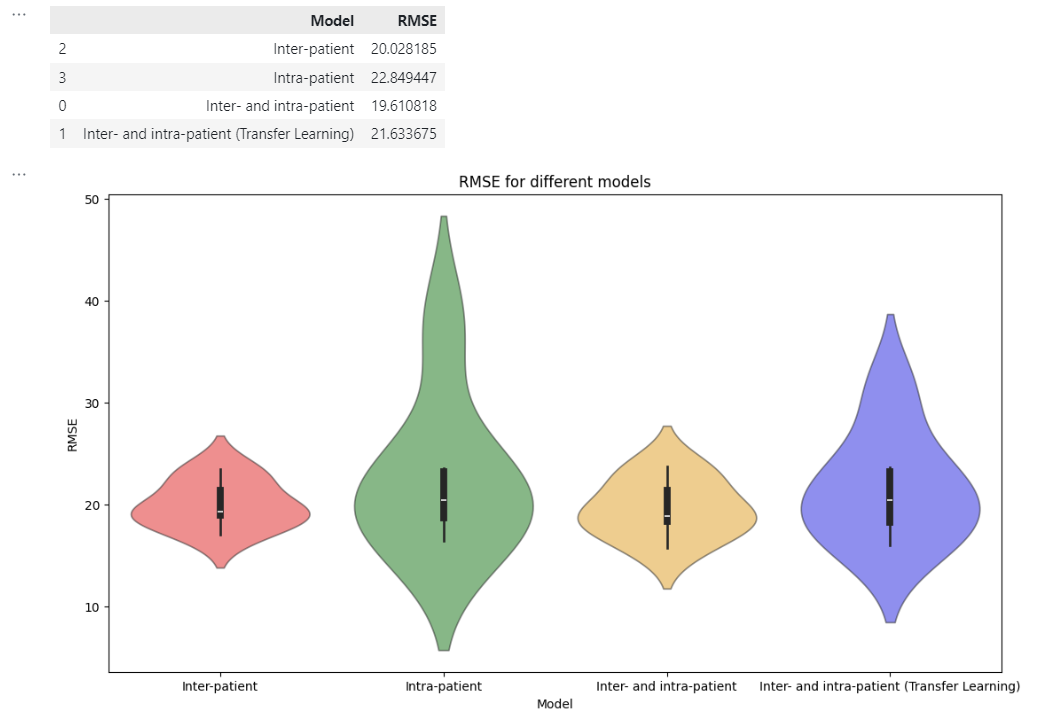

### 60 minute forecast

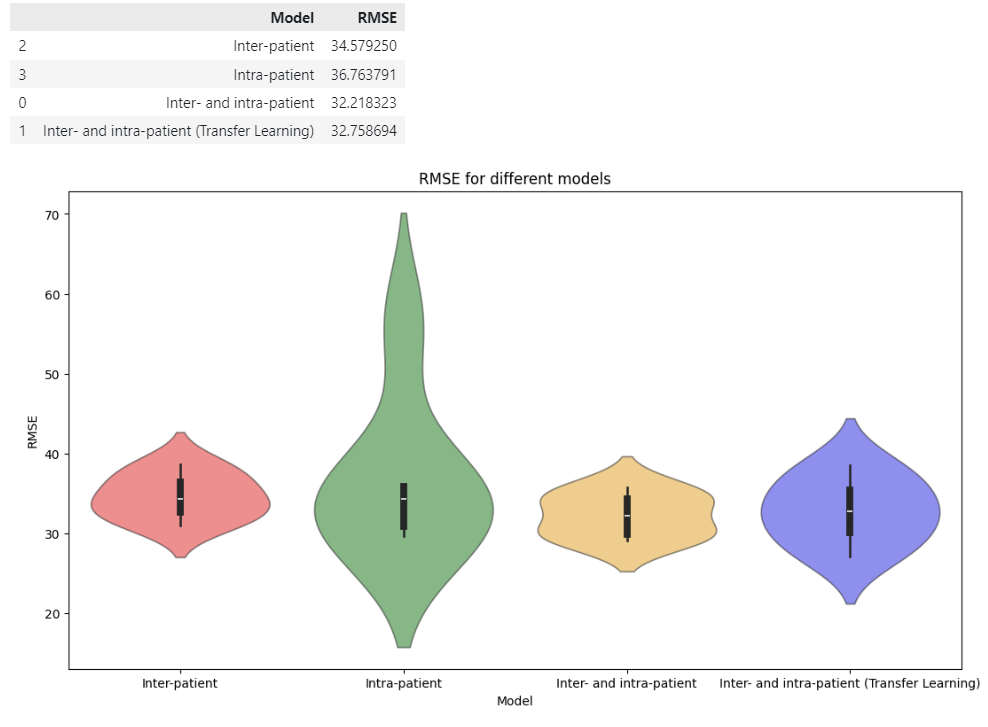

### 120 minute forecast

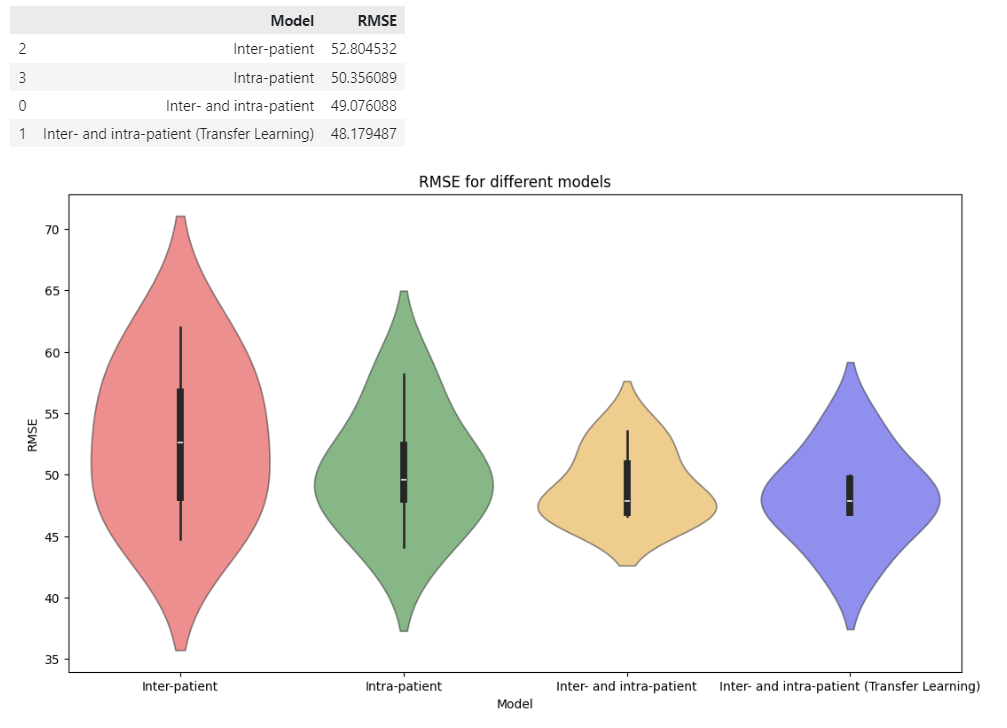

## Conclusion
This section provides a snapshot of how the models stack up against each other and the state-of-the-art models showcased in the survey paper [1]. The observations presented here represent only an initial glimpse— and robust statistical tests would be necessary to fully substantiate these claims, so take them with a pinch of salt for now.

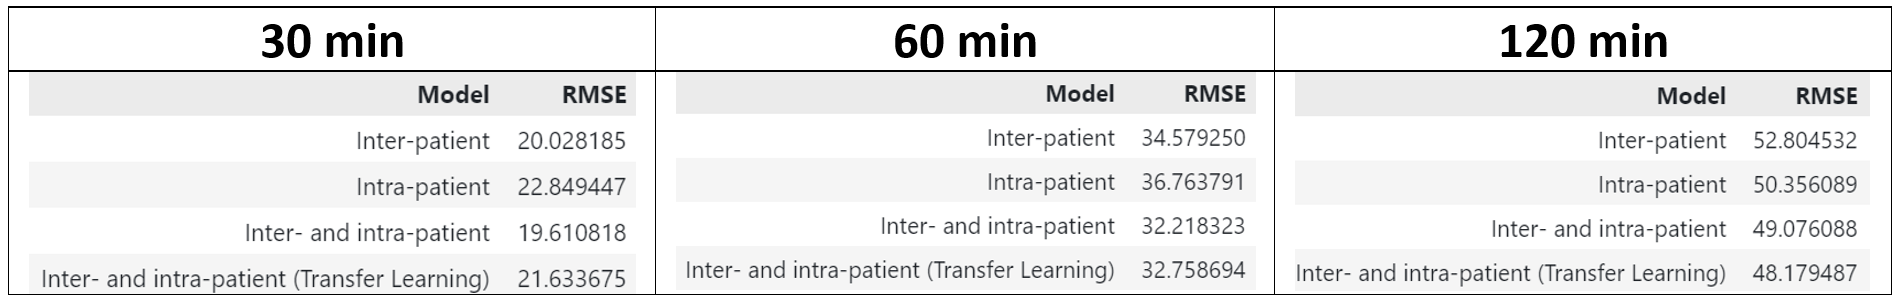

### Model Comparison

#### 30-minute Predictions
The Inter- and Intra-patient model achieves the best performance with the lowest RMSE, indicating that a hybrid approach that leverages data from both within and across individuals can effectively predict blood glucose levels in the short term.
Interestingly, the Inter-patient model outperforms the Intra-patient model, suggesting that patterns learned from a wider patient population are more predictive in this time frame than those learned from individual-specific data. This might be due to the limited amount of training data for each person, as can also be seen from the high varaince in results per participant.
The Transfer Learning approach, while still performing well, does not quite match the performance of the hybrid model without transfer learning.
#### 60-minute Predictions
The RMSE values increase across all models as the forecasting interval extends to 60 minutes, which is expected due to the increasing uncertainty with longer prediction times.
Again, the Inter- and Intra-patient model shows a leading performance, reinforcing the advantage of combining generalized and personalized data.
The Transfer Learning variant shows a slight improvement over its intra- and inter model counterparts.
#### 120-minute Predictions
As the forecasting horizon stretches to 120 minutes, all models naturally experience an increase in RMSE due to the growing difficulty of making accurate long-term predictions.
The Inter-patient model now has a higher RMSE than the Intra-patient model, which could indicate that individual patient data holds more predictive power for longer-term forecasts.
Notably, the Inter- and Intra-patient model with Transfer Learning achieves the best results, suggesting that leveraging pre-learned patterns with subsequent fine-tuning on specific patient data may be particularly effective for long-range predictions.
In summary, the hybrid Inter- and Intra-patient modeling approach consistently performs well across all time horizons, with the Transfer Learning method showing particular promise for the longest prediction interval of 120 minutes.

Based on this (extremely!) preliminary analysis, it appears that, as anticipated, employing models trained on both population-level data and individual-specific data offers advantages. Furthermore, the observed performance of the transfer learning approach is promising, suggesting its potential effectiveness in this context. Given a sufficiently large dataset, it stands to reason that fine-tuning a pre-trained model to fit an individual participant could yield even more significant improvements. This hypothesis aligns with the notion that personalized adjustments to a broadly trained model can enhance its predictive accuracy for individual cases.

### Comparisons with state-of-the-art

Results from survey paper [2]:

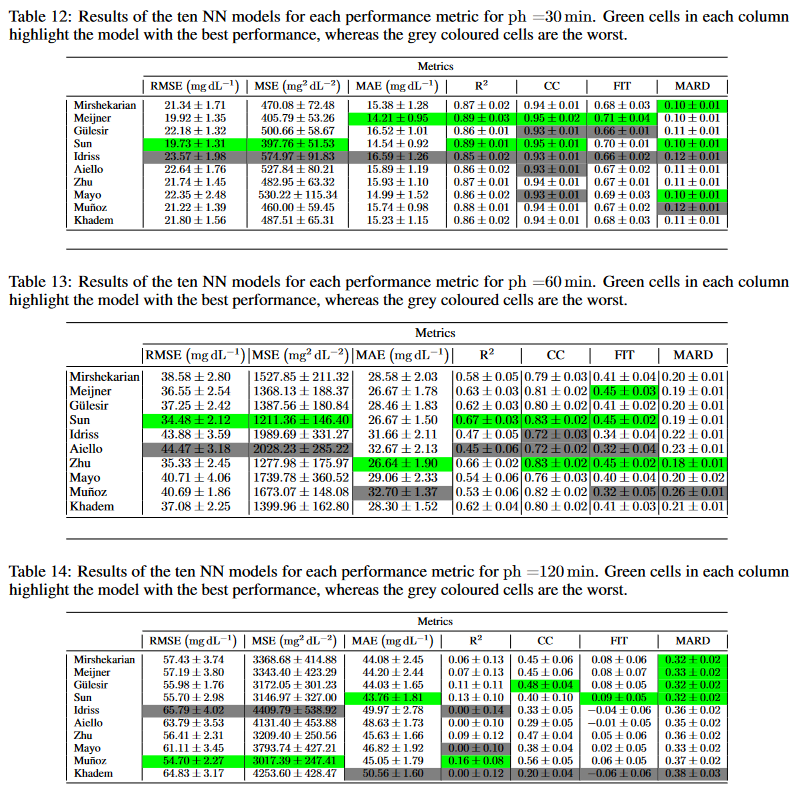


For the 30-minute forecast, the Inter- and Intra-patient models perform comparably to the top-performing models from the first image, such as the Mirshekarian model, which has a similar RMSE. This suggests that these models are quite effective for short-term predictions.

Moving to the 60-minute forecast, the models show an increase in RMSE across the board, as expected with the complexity of predicting further into the future. However, the Inter-patient and Inter- and Intra-patient models still deliver a lower RMSE compared to some state-of-the-art models, indicating robustness in medium-term forecasting.

For the 120-minute forecast, the challenge of long-term prediction becomes more evident with generally higher RMSE values. Despite this, the Inter- and Intra-patient (Transfer Learning) model stands out with a lower RMSE than the Mirshekarian model, hinting at the effectiveness of transfer learning for capturing the nuanced patterns needed for longer-term forecasts.

Overall, while not every model outperforms the state-of-the-art across all timeframes, the Inter- and Intra-patient models, especially with the application of transfer learning, show that they can hold their own against established benchmarks. This is particularly true for longer prediction horizons, where the nuanced adaptation to individual patients' data seems to offer an edge.

## Future Work


For a more comprehensive comparison, it would be useful to add more evaluation metrics and incorporate statistical analysis to discern the significance of the results. Exploring alternative LSTM architectures, as well as transformer models, could provide deeper insights into the modeling capabilities. Additionally, there's room for improvement in the tuning of hyperparameters, which could be enhanced by the application of cross-validation techniques, ensuring a more effective use of the data. To gain a clearer understanding of how features influence predictions spatially and temporally, methods like occlusion plots or saliency maps should be employed.

A subsequent analysis should also include data from the participants from 2020. The choice between using only continuous blood glucose (CBG) values versus a full feature set warrants further investigation. 

Retrospectively, the decision to employ cubic splines for imputing missing CBG values may have implications for the predictions, as this interpolation could inadvertently smooth out genuine fluctuations in blood glucose levels, potentially impacting the target variable in the models.

## References
[1]	Tena, Felix, et al. "A Critical Review of the state-of-the-art on Deep Neural Networks for Blood Glucose Prediction in Patients with Diabetes." arXiv preprint arXiv:2109.02178 (2021).

[2]	Cui, Ran, et al. "Personalised short-term glucose prediction via recurrent self-attention network." 2021 IEEE 34th International Symposium on Computer-Based Medical Systems (CBMS). IEEE, 2021.

[3] Cindy Marling and Razvan Bunescu. The ohiot1dm dataset for blood glucose level prediction: Update 2020. 2020.

[4] S. Mirshekarian, R. Bunescu, C. Marling, and F. Schwartz. Using lstms to learn physiological models of blood glucose behavior. In 2017 39th Annual International Conference of the IEEE Engineering in Medicine and Biology Society (EMBC), pages 2887–2891.